# Random Forest Model Code

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_text
from sklearn import tree
from graphviz import Source
from IPython.display import SVG
import os, requests
import random
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Loading and Preprocessing

In [3]:
# Retrieve files names of the input/output data
# Need to make sure your path is correct

hc_files = sorted(glob.glob('/content/drive/MyDrive/CSCI 5527/Rat Data From Dave/Valid Trials Data/*_KDHC.dat'))
pf_files = sorted(glob.glob('/content/drive/MyDrive/CSCI 5527/Rat Data From Dave/Valid Trials Data/*_KDPF.dat'))
target_files = sorted(glob.glob('/content/drive/MyDrive/CSCI 5527/Rat Data From Dave/Valid Trials Data/*_KD.csv'))

# If you want to use the RD data (some future cells might not work depending on the number of neurons/sessions in RD data)
#hc_files = sorted(glob.glob('/content/drive/MyDrive/CSCI 5527/Rat Data From Dave/Valid Trials Data/*_RDHC.dat'))
#pf_files = sorted(glob.glob('/content/drive/MyDrive/CSCI 5527/Rat Data From Dave/Valid Trials Data/*_RDPF.dat'))
#target_files = sorted(glob.glob('/content/drive/MyDrive/CSCI 5527/Rat Data From Dave/Valid Trials Data/*_RD.csv'))

print(len(hc_files))
print(len(pf_files))
print(len(target_files))

26
26
26


In [4]:
# Read in data for each session into a list

hc_data = []
targets = []

pf_data = []
pf_targets = []

# Get into trials x neurons x timestamp format
for i in range(len(hc_files)):

  hc_df = pd.read_csv(hc_files[i], delimiter=',')
  hc_data.append(hc_df.values.reshape(hc_df.shape[0],int(hc_df.shape[1]/400),400))

  pf_df = pd.read_csv(pf_files[i], delimiter=',')
  pf_data.append(pf_df.values.reshape(pf_df.shape[0],int(pf_df.shape[1]/400),400))

  targets.append(pd.read_csv(target_files[i], delimiter=','))
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [5]:
# Determine the amount of neurons/trials each session has as well as the minimum amount of neurons/trials across sessions

hc_num_neurons = np.array([])
hc_num_trials = np.array([])
pf_num_neurons = np.array([])
pf_num_trials = np.array([])

for i in range(len(hc_data)):
  hc_num_neurons = np.append(hc_num_neurons, hc_data[i].shape[1])
  hc_num_trials = np.append(hc_num_trials, hc_data[i].shape[0])

  pf_num_neurons = np.append(pf_num_neurons, pf_data[i].shape[1])
  pf_num_trials = np.append(pf_num_trials, pf_data[i].shape[0])

hc_min_neurons = int(min(hc_num_neurons))
hc_min_trials = int(min(hc_num_trials))

pf_min_neurons = int(min(pf_num_neurons))
pf_min_trials = int(min(pf_num_trials))

print(hc_min_neurons)
print(pf_min_neurons)

13
5


In [6]:
print(hc_num_neurons)
print((pf_num_neurons))

[31. 15. 16. 13. 85. 48. 48. 36. 44. 63. 41. 59. 41. 43. 21. 18. 41. 38.
 23. 44. 59. 26. 54. 66. 56. 40.]
[13.  9.  5.  6. 26. 18. 23. 18. 68. 69. 63. 47. 50. 51. 53. 42. 55. 42.
 37. 78. 71. 54.  5. 10.  8. 22.]


Arranging data into various formats by doing different operations and/or using only certain sessions/neurons:

Pick one cell to run to use for testing the RF model later on.

In [7]:
# Use all sessions but only the minimum number of neurons in HC and PF data respectively (13 and 5)
# Resulting format: trials x (neurons * timestamps)

hc_sample = hc_data[0][:,0:hc_min_neurons,:]
hc_spike_data = hc_sample.reshape(hc_sample.shape[0], hc_sample.shape[1]*hc_sample.shape[2])

pf_sample = pf_data[0][:,0:pf_min_neurons,:]
pf_spike_data = pf_sample.reshape(pf_sample.shape[0], pf_sample.shape[1]*pf_sample.shape[2])

target_data = targets[0]

for j in range(1, len(hc_data)):

  hc_sample = hc_data[j][:,0:hc_min_neurons,:]
  hc_spike = hc_sample.reshape(hc_sample.shape[0], hc_sample.shape[1]*hc_sample.shape[2])

  pf_sample = pf_data[j][:,0:pf_min_neurons,:]
  pf_spike = pf_sample.reshape(pf_sample.shape[0], pf_sample.shape[1]*pf_sample.shape[2])

  hc_spike_data = np.vstack((hc_spike_data, hc_spike))
  pf_spike_data = np.vstack((pf_spike_data, pf_spike))

  target_data = np.append(target_data, targets[j])

print(hc_spike_data.shape)
print(pf_spike_data.shape)
print(target_data.shape)

(2801, 5200)
(2801, 2000)
(2801,)


In [36]:
# Use all sessions but only the minimum number of neurons in HC and PF data respectively (13 and 5)
# Take random min. neurons instead of first amount
# Resulting format: trials x (neurons * timestamps)

hc_sample = hc_data[0][:,np.random.choice(hc_data[0].shape[1], 13, replace = False),:]
hc_spike_data = hc_sample.reshape(hc_sample.shape[0], hc_sample.shape[1]*hc_sample.shape[2])

pf_sample = pf_data[0][:,np.random.choice(pf_data[0].shape[1], 5, replace = False),:]
pf_spike_data = pf_sample.reshape(pf_sample.shape[0], pf_sample.shape[1]*pf_sample.shape[2])

target_data = targets[0]

for j in range(1, len(hc_data)):

  hc_sample = hc_data[j][:,np.random.choice(hc_data[j].shape[1], 13, replace = False),:]
  hc_spike = hc_sample.reshape(hc_sample.shape[0], hc_sample.shape[1]*hc_sample.shape[2])

  pf_sample = pf_data[j][:,np.random.choice(pf_data[j].shape[1], 5, replace = False),:]
  pf_spike = pf_sample.reshape(pf_sample.shape[0], pf_sample.shape[1]*pf_sample.shape[2])

  hc_spike_data = np.vstack((hc_spike_data, hc_spike))
  pf_spike_data = np.vstack((pf_spike_data, pf_spike))

  target_data = np.append(target_data, targets[j])

print(hc_spike_data.shape)
print(pf_spike_data.shape)
print(target_data.shape)

(2801, 5200)
(2801, 2000)
(2801,)


In [37]:
# Use top 15 sessions with largest amount of neurons from PF data and corresponding HC sessions
# Determined through manual inspection, sessions should be the same for HC and PF
# Resulting format: trials x (neurons * timestamps)

hc_data_2 = (np.array(hc_data)[np.argsort(pf_num_neurons)])[11:len(hc_data)]
targets_2 = (np.array(targets)[np.argsort(pf_num_neurons)])[11:len(targets)]
pf_data_2 = (np.array(pf_data)[np.argsort(pf_num_neurons)])[11:len(pf_data)]

print(len(hc_data_2),len(targets_2),len(pf_data_2))

hc_min_neurons = 18
pf_min_neurons = 26

hc_sample = hc_data_2[0][:,0:hc_min_neurons,:]
hc_spike_data = hc_sample.reshape(hc_sample.shape[0], hc_sample.shape[1]*hc_sample.shape[2])

pf_sample = pf_data_2[0][:,0:pf_min_neurons,:]
pf_spike_data = pf_sample.reshape(pf_sample.shape[0], pf_sample.shape[1]*pf_sample.shape[2])

target_data = targets_2[0]

for j in range(1, len(hc_data_2)):

  hc_sample = hc_data_2[j][:,0:hc_min_neurons,:]
  hc_spike = hc_sample.reshape(hc_sample.shape[0], hc_sample.shape[1]*hc_sample.shape[2])

  pf_sample = pf_data_2[j][:,0:pf_min_neurons,:]
  pf_spike = pf_sample.reshape(pf_sample.shape[0], pf_sample.shape[1]*pf_sample.shape[2])

  hc_spike_data = np.vstack((hc_spike_data, hc_spike))
  pf_spike_data = np.vstack((pf_spike_data, pf_spike))

  target_data = np.append(target_data, targets_2[j])

print(hc_spike_data.shape)
print(pf_spike_data.shape)
print(target_data.shape)

<ipython-input-37-67d3a5d812f6>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hc_data_2 = (np.array(hc_data)[np.argsort(pf_num_neurons)])[11:len(hc_data)]
<ipython-input-37-67d3a5d812f6>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  targets_2 = (np.array(targets)[np.argsort(pf_num_neurons)])[11:len(targets)]
<ipython-input-37-67d3a5d812f6>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

15 15 15
(1733, 7200)
(1733, 10400)
(1733,)


In [39]:
# Only use sessions which have at least 38 neurons (17 and 13 for HC and PF respectively)
# HC and PF sessions will likely differ, so cannot concatenate later
# Resulting format: trials x (neurons * timestamps)

# Limit data to sessions with >= 38 neurons
hc_data_2 = (np.array(hc_data)[hc_num_neurons >= 38])
hc_targets_2 = (np.array(targets)[hc_num_neurons >= 38])
pf_data_2 = (np.array(pf_data)[pf_num_neurons >= 38])
pf_targets_2 = (np.array(targets)[pf_num_neurons >= 38])

print(np.sum([hc_num_neurons >= 38]), np.sum([pf_num_neurons >= 38]))

hc_sample = hc_data_2[0][:,0:38,:]
hc_spike_data = hc_sample.reshape(hc_sample.shape[0],hc_sample.shape[1]*hc_sample.shape[2])

pf_sample = pf_data_2[0][:,0:38,:]
pf_spike_data = pf_sample.reshape(pf_sample.shape[0],pf_sample.shape[1]*pf_sample.shape[2])

hc_target_data = hc_targets_2[0]
pf_target_data = pf_targets_2[0]

for j in range(1, len(hc_data_2)):

  hc_sample = hc_data_2[j][:,0:38,:]
  hc_spike = hc_sample.reshape(hc_sample.shape[0],hc_sample.shape[1]*hc_sample.shape[2])


  hc_spike_data = np.vstack((hc_spike_data, hc_spike))

  hc_target_data = np.append(hc_target_data, hc_targets_2[j])

for j in range(1, len(pf_data_2)):


  pf_sample = pf_data_2[j][:,0:38,:]
  pf_spike = pf_sample.reshape(pf_sample.shape[0],pf_sample.shape[1]*pf_sample.shape[2])

  pf_spike_data = np.vstack((pf_spike_data, pf_spike))

  pf_target_data = np.append(pf_target_data, pf_targets_2[j])

print(hc_spike_data.shape)
print(pf_spike_data.shape)
print(hc_target_data.shape)
print(pf_target_data.shape)

<ipython-input-39-c5a121d9b737>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hc_data_2 = (np.array(hc_data)[hc_num_neurons >= 38])
<ipython-input-39-c5a121d9b737>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hc_targets_2 = (np.array(targets)[hc_num_neurons >= 38])
<ipython-input-39-c5a121d9b737>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when crea

17 13
(1687, 15200)
(1533, 15200)
(1687,)
(1533,)


In [40]:
# Use all sessions but only the minimum number of neurons in HC and PF data respectively
# Then sum across neurons
# Resulting format: trials x timestamps

hc_spike_data = np.array([])
target_data = np.array([])
pf_spike_data = np.array([])

hc_sample = np.sum(hc_data[0][:,0:hc_min_neurons,:], axis=1)
hc_spike_data = hc_sample

pf_sample = np.sum(pf_data[0][:,0:pf_min_neurons,:], axis=1)
pf_spike_data = pf_sample

target_data = targets[0]

for j in range(1, len(hc_data)):

  hc_sample = np.sum(hc_data[j][:,0:hc_min_neurons,:], axis=1)
  hc_spike = hc_sample

  pf_sample = np.sum(pf_data[j][:,0:pf_min_neurons,:], axis=1)
  pf_spike = pf_sample

  hc_spike_data = np.vstack((hc_spike_data, hc_spike))
  pf_spike_data = np.vstack((pf_spike_data, pf_spike))

  target_data = np.append(target_data, targets[j])

print(hc_spike_data.shape)
print(pf_spike_data.shape)
print(target_data.shape)

(2801, 400)
(2801, 400)
(2801,)


In [41]:
# Use all sessions by summing across all neurons
# Resulting Format: trials x timestamps

hc_spike_data = np.array([])
target_data = np.array([])
pf_spike_data = np.array([])

hc_sample = np.sum(hc_data[0],axis=1)
hc_spike_data = hc_sample

pf_sample = np.sum(pf_data[0],axis=1)
pf_spike_data = pf_sample

target_data = targets[0]

for j in range(1, len(hc_data)):

  hc_spike = np.sum(hc_data[j],axis=1)

  pf_spike = np.sum(pf_data[j],axis=1)

  hc_spike_data = np.vstack((hc_spike_data, hc_spike))
  pf_spike_data = np.vstack((pf_spike_data, pf_spike))

  target_data = np.append(target_data, targets[j])

print(hc_spike_data.shape)
print(pf_spike_data.shape)
print(target_data.shape)

(2801, 400)
(2801, 400)
(2801,)


In [42]:
# Use all available data by putting it into long format
# Resulting format: (trials * neurons) x timestamps

hc_sample = hc_data[0]
hc_spike_data = hc_sample.reshape(hc_sample.shape[0]*hc_sample.shape[1], hc_sample.shape[2])

pf_sample = pf_data[0]
pf_spike_data = pf_sample.reshape(pf_sample.shape[0]*pf_sample.shape[1], pf_sample.shape[2])

# Need to repeat target variable since each set of neurons is from same trial / resulting target
hc_target_data = np.repeat(np.array(targets[0]).flatten(), hc_data[0].shape[1])
pf_target_data = np.repeat(np.array(targets[0]).flatten(), pf_data[0].shape[1])

for j in range(1, len(hc_data)):

  hc_sample = hc_data[j]
  hc_spike = hc_sample.reshape(hc_sample.shape[0]*hc_sample.shape[1], hc_sample.shape[2])

  pf_sample = pf_data[j]
  pf_spike = pf_sample.reshape(pf_sample.shape[0]*pf_sample.shape[1], pf_sample.shape[2])

  hc_spike_data = np.vstack((hc_spike_data, hc_spike))
  pf_spike_data = np.vstack((pf_spike_data, pf_spike))

  hc_target_data = np.append(hc_target_data, np.repeat(np.array(targets[j]).flatten(), hc_data[j].shape[1]))
  pf_target_data = np.append(pf_target_data, np.repeat(np.array(targets[j]).flatten(), pf_data[j].shape[1]))

print(hc_spike_data.shape)
print(pf_spike_data.shape)
print(hc_target_data.shape)
print(pf_target_data.shape)

(106474, 400)
(106582, 400)
(106474,)
(106582,)


Optionally concatenate HC and PF inpute data together, usually results in better performance.

In [28]:
# Concatenate HC anf PF Data together as long the have the same .shape[0] dimension
# Do not need to concatenate targets since they should be the same in this case

hc_pf_data = np.hstack((hc_spike_data, pf_spike_data))

print(hc_pf_data.shape)

(2801, 7200)


Do a train/test split on the input/output data

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert to PyTorch tensor and move to the appropriate device
X = torch.from_numpy(hc_pf_data).to(device)
y = torch.from_numpy(target_data).to(device)

Using device: cpu


In [30]:
# Split input into train/test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


Run the Random Forest model

Recommended: Run the RF model on fixed random state train/test data in order to test out the optimal value for n_estimators, and then run 3 times in next cell to get mean test accuracy.

In [34]:
# Initialize RF model, train model, predict on test data, print accuraacy

optimal_nest = 450

model = RandomForestClassifier(n_estimators=optimal_nest, random_state=24)

model.fit(X_train, y_train)

y_predict = model.predict(X_test)

print(accuracy_score(y_test, y_predict))
print(roc_auc_score(y_test, y_predict))

0.6356756756756756
0.588199067421332


In [35]:
# Train model and predict 3 times and print out mean accuracy and std
accuracy_scores = []

for i in range(3):

  # Split input into train/test data

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

  X_train = X_train.to(device)
  X_test = X_test.to(device)
  y_train = y_train.to(device)
  y_test = y_test.to(device)

  model = RandomForestClassifier(n_estimators=optimal_nest, random_state=24)
  model.fit(X_train, y_train)

  y_predict = model.predict(X_test)

  accuracy_scores.append(accuracy_score(y_test, y_predict))

print("Mean Test Accuracy: ", np.mean(accuracy_scores))
print("Standard Deviation of Test Accuracy: ", np.std(accuracy_scores))

Mean Test Accuracy:  0.6410810810810811
Standard Deviation of Test Accuracy:  0.010406867804103515


In [27]:
accuracy_scores

[0.5772972972972973, 0.56, 0.5697297297297297]

In [ ]:
# Calculate NIR for test target data

NIR_Num = sum(y_test==0).int()
NIR_Den = len(y_test)
NIR = max((NIR_Num/NIR_Den),1-(NIR_Num/NIR_Den))
print(NIR)

tensor(0.5996)


In [ ]:
# Perform 5-fold cross validation

k = 5

kf = KFold(n_splits=k, shuffle=True, random_state=24)

validation = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")

print(np.mean(validation))

0.5751617021276596


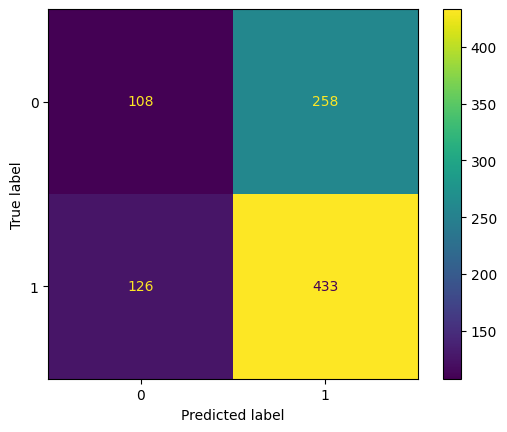

In [25]:
# Plot confusion matrix

cm = confusion_matrix(y_test, y_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()